# Project M3 – Air Quality Prediction (Blocks 3 & 4)

**Course:** Data Analysis & Pattern Recognition  
**Dataset:** UCI Air Quality Dataset (Kaggle)  
**Target variable:** CO(GT) – Carbon Monoxide concentration (mg/m³)  

**Group Members:**
- Student 1: Sofianopoulou Apostolia Maria (AT8397455)
- Student 2: Name (ID)
- Student 3: Name (ID)
- Student 4: Name (ID)

## 1. Data Preprocessing Pipeline

**Improvements over original:**
- ✅ Reproducibility: Random seeds set for all libraries
- ✅ Drop NMHC_GT (90% missing values)
- ✅ Forward-fill imputation (respects temporal order)
- ✅ Cyclical encoding for hour, day_of_week, month
- ✅ Lag features (1h, 2h, 3h, 6h, 12h, 24h)
- ✅ Rolling statistics (24h mean/std)
- ✅ Target scaling for neural networks
- ✅ Sequence creation helper for LSTM/GRU
- ✅ Metrics calculation function

**Output:**
- `air_quality_preprocessed.csv` - Preprocessed data with splits
- `feature_scaler.pkl` - StandardScaler for features
- `target_scaler.pkl` - StandardScaler for target
- `feature_cols.pkl` - Feature column names (for consistent ordering)

### 1.1 Setup & Reproducibility

In [1]:
# ============================================================
# 1.1 SETUP & REPRODUCIBILITY
# ============================================================
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility (REQUIRED by project)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# For PyTorch (uncomment when using Block 4)
# import torch
# torch.manual_seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(SEED)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"Random seed set to: {SEED}")

Random seed set to: 42


In [2]:
# ============================================================
# COLAB SETUP (uncomment if running on Google Colab)
# ============================================================
# from google.colab import drive
# import kagglehub

# drive.mount('/content/drive')
# BASE_PATH = "/content/drive/MyDrive/DAPR_FinalProject"  # <- ADAPT PATH!

# # Download UCI Air Quality dataset
# DATA_PATH = kagglehub.dataset_download("nishantbhadauria/datasetucimlairquality")
# print("Dataset path:", DATA_PATH)

# ============================================================
# LOCAL SETUP (for local development)
# ============================================================
BASE_PATH = "."  # Current directory
DATA_PATH = "./data"  # Adjust to your data location

# Create output directory
os.makedirs(f"{BASE_PATH}/outputs", exist_ok=True)

### 1.2 Load Raw Data

In [3]:
# ============================================================
# 1.2 LOAD RAW DATA
# ============================================================
# Note: The UCI Air Quality dataset from Kaggle uses:
# - Comma as delimiter
# - Period as decimal separator
# - UTF-8 encoding with BOM
# - Two trailing empty columns

csv_path = os.path.join(DATA_PATH, "AirQualityUCI.csv")

# Load CSV with proper settings
df_raw = pd.read_csv(csv_path, encoding='utf-8-sig')  # utf-8-sig handles BOM

# Drop empty trailing columns
df_raw = df_raw.dropna(axis=1, how='all')

print(f"Raw shape: {df_raw.shape}")
print(f"\nColumns: {df_raw.columns.tolist()}")
print(f"\nFirst rows:")
df_raw.head()

Raw shape: (9471, 15)

Columns: ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

First rows:


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
# Check column names and standardize
# The dataset may have different column naming conventions
print("Column dtypes:")
print(df_raw.dtypes)

# Rename columns to consistent format (remove parentheses, spaces)
column_mapping = {
    'CO(GT)': 'CO_GT',
    'PT08.S1(CO)': 'PT08_S1_CO',
    'NMHC(GT)': 'NMHC_GT',
    'C6H6(GT)': 'C6H6_GT',
    'PT08.S2(NMHC)': 'PT08_S2_NMHC',
    'NOx(GT)': 'Nox_GT',
    'PT08.S3(NOx)': 'PT08_S3_Nox',
    'NO2(GT)': 'NO2_GT',
    'PT08.S4(NO2)': 'PT08_S4_NO2',
    'PT08.S5(O3)': 'PT08_S5_O3',
}

# Apply mapping only for columns that exist
df_raw = df_raw.rename(columns={k: v for k, v in column_mapping.items() if k in df_raw.columns})
print(f"\nRenamed columns: {df_raw.columns.tolist()}")

Column dtypes:
Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

Renamed columns: ['Date', 'Time', 'CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT', 'PT08_S2_NMHC', 'Nox_GT', 'PT08_S3_Nox', 'NO2_GT', 'PT08_S4_NO2', 'PT08_S5_O3', 'T', 'RH', 'AH']


### 1.3 Datetime Parsing & Initial EDA

In [5]:
# ============================================================
# 1.3 DATETIME PARSING
# ============================================================
# First, drop rows with empty Date/Time values
n_before = len(df_raw)
df_raw = df_raw.dropna(subset=["Date", "Time"])
print(f"Dropped {n_before - len(df_raw)} rows with empty Date/Time")

print(f"\nSample Date values: {df_raw['Date'].head().tolist()}")
print(f"Sample Time values: {df_raw['Time'].head().tolist()}")

# The UCI Air Quality dataset uses US format: M/D/YYYY
# (confirmed: second number goes up to 31, meaning it's the day)
df_raw["datetime_str"] = df_raw["Date"].astype(str) + " " + df_raw["Time"].astype(str)

# Parse with US format (month/day/year)
df_raw["datetime"] = pd.to_datetime(df_raw["datetime_str"], format="%m/%d/%Y %H:%M:%S")

df_raw = df_raw.drop(columns=["datetime_str"])

print(f"\nParsed {df_raw['datetime'].notna().sum()}/{len(df_raw)} datetimes")
print(f"Date range: {df_raw['datetime'].min()} to {df_raw['datetime'].max()}")

Dropped 114 rows with empty Date/Time

Sample Date values: ['3/10/2004', '3/10/2004', '3/10/2004', '3/10/2004', '3/10/2004']
Sample Time values: ['18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00']

Parsed 9357/9357 datetimes
Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00


In [6]:
# Sort chronologically and reset index
df_raw = df_raw.sort_values("datetime").reset_index(drop=True)
print(f"Shape after datetime parsing: {df_raw.shape}")

# Define target column
TARGET_COL = "CO_GT"

# Get numeric columns for analysis
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols}")

Shape after datetime parsing: (9357, 16)

Numeric columns (13): ['CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT', 'PT08_S2_NMHC', 'Nox_GT', 'PT08_S3_Nox', 'NO2_GT', 'PT08_S4_NO2', 'PT08_S5_O3', 'T', 'RH', 'AH']


In [7]:
# ============================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================
# Replace -200 with NaN for EDA
df_eda = df_raw.copy()
df_eda[numeric_cols] = df_eda[numeric_cols].replace(-200, np.nan)

print("Summary Statistics:")
print(df_eda[numeric_cols].describe().round(2))

print("\n" + "="*50)
print("MISSING VALUES (-200 → NaN):")
print("="*50)
missing = df_eda[numeric_cols].isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df_eda) * 100).round(1)
missing_df = pd.DataFrame({"Missing": missing, "Percent": missing_pct})
print(missing_df[missing_df["Missing"] > 0])

Summary Statistics:
         CO_GT  PT08_S1_CO  NMHC_GT  C6H6_GT  PT08_S2_NMHC   Nox_GT  \
count  7674.00     8991.00   914.00  8991.00       8991.00  7718.00   
mean      2.15     1099.83   218.81    10.08        939.15   246.90   
std       1.45      217.08   204.46     7.45        266.83   212.98   
min       0.10      647.00     7.00     0.10        383.00     2.00   
25%       1.10      937.00    67.00     4.40        734.50    98.00   
50%       1.80     1063.00   150.00     8.20        909.00   180.00   
75%       2.90     1231.00   297.00    14.00       1116.00   326.00   
max      11.90     2040.00  1189.00    63.70       2214.00  1479.00   

       PT08_S3_Nox   NO2_GT  PT08_S4_NO2  PT08_S5_O3        T       RH  \
count      8991.00  7715.00      8991.00     8991.00  8991.00  8991.00   
mean        835.49   113.09      1456.26     1022.91    18.32    49.23   
std         256.82    48.37       346.21      398.48     8.83    17.32   
min         322.00     2.00       551.00    

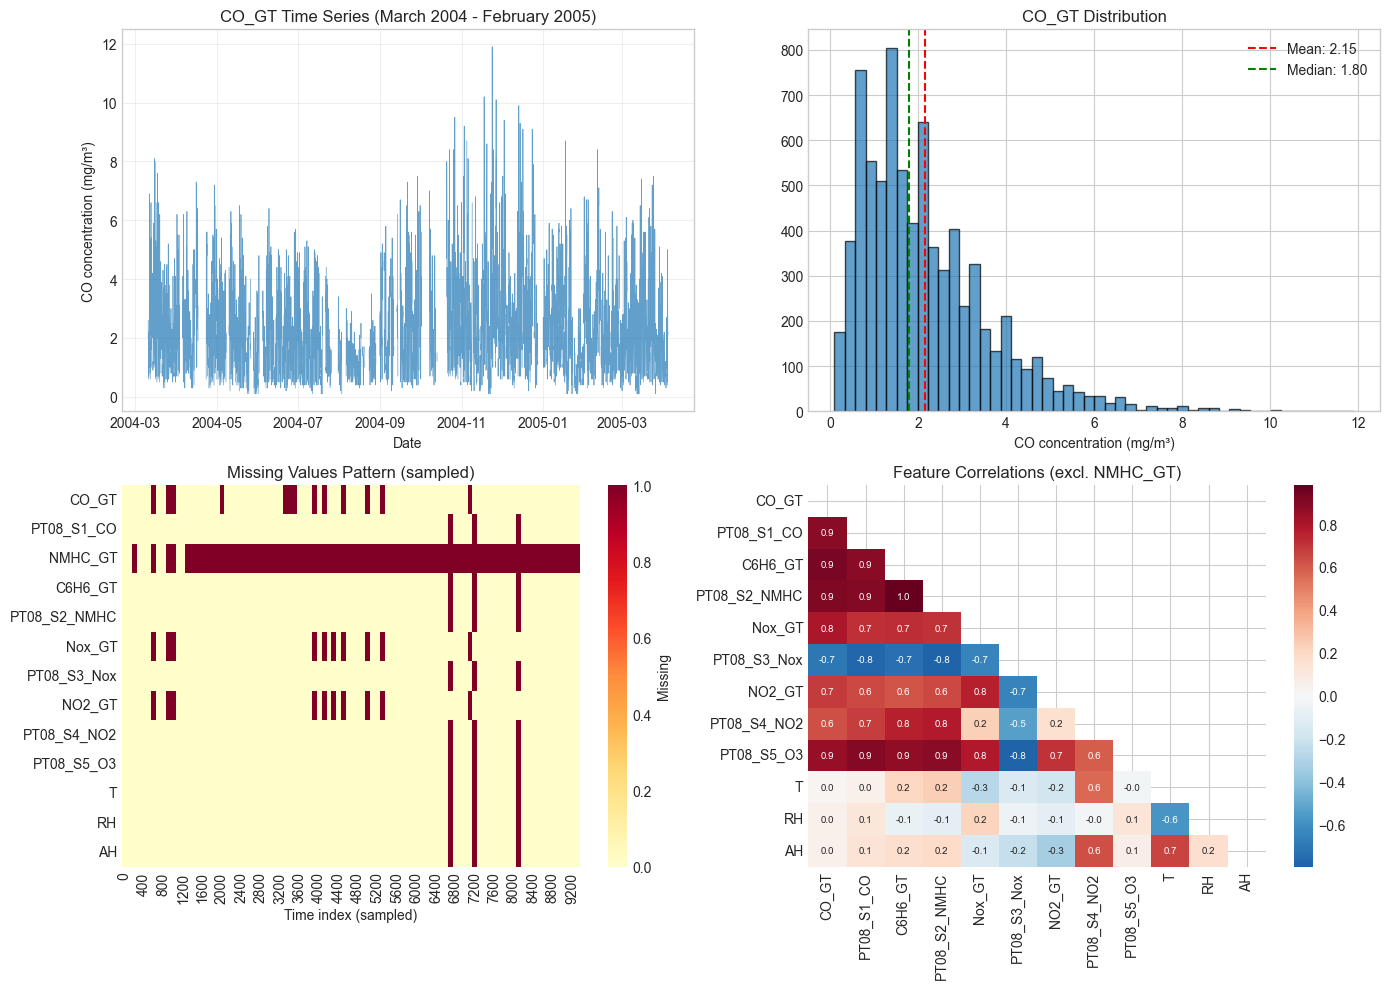

In [8]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Time series of CO(GT)
ax = axes[0, 0]
ax.plot(df_eda["datetime"], df_eda[TARGET_COL], linewidth=0.5, alpha=0.7)
ax.set_title(f"{TARGET_COL} Time Series (March 2004 - February 2005)")
ax.set_xlabel("Date")
ax.set_ylabel("CO concentration (mg/m³)")
ax.grid(alpha=0.3)

# 2. Distribution of CO(GT)
ax = axes[0, 1]
df_eda[TARGET_COL].hist(ax=ax, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(df_eda[TARGET_COL].mean(), color='red', linestyle='--', label=f'Mean: {df_eda[TARGET_COL].mean():.2f}')
ax.axvline(df_eda[TARGET_COL].median(), color='green', linestyle='--', label=f'Median: {df_eda[TARGET_COL].median():.2f}')
ax.set_title(f"{TARGET_COL} Distribution")
ax.set_xlabel("CO concentration (mg/m³)")
ax.legend()

# 3. Missing values heatmap
ax = axes[1, 0]
missing_matrix = df_eda[numeric_cols].isna().astype(int)
# Sample for visualization (every 100th row)
sample_idx = range(0, len(missing_matrix), 100)
sns.heatmap(missing_matrix.iloc[sample_idx].T, cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Missing'})
ax.set_title("Missing Values Pattern (sampled)")
ax.set_xlabel("Time index (sampled)")

# 4. Correlation matrix (excluding highly missing NMHC_GT)
ax = axes[1, 1]
cols_for_corr = [c for c in numeric_cols if c != 'NMHC_GT']
corr_matrix = df_eda[cols_for_corr].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, ax=ax, 
            annot=True, fmt='.1f', annot_kws={'size': 7})
ax.set_title("Feature Correlations (excl. NMHC_GT)")

plt.tight_layout()
plt.savefig(f"{BASE_PATH}/outputs/eda_plots.png", dpi=150, bbox_inches='tight')
plt.show()

### 1.4 Handle Missing Values

In [9]:
# ============================================================
# 1.4 HANDLE MISSING VALUES
# ============================================================
df = df_raw.copy()

# Replace -200 with NaN
df[numeric_cols] = df[numeric_cols].replace(-200, np.nan)

# IMPORTANT: Drop NMHC_GT - it has ~90% missing values
# Mean imputation would be meaningless for this column
if 'NMHC_GT' in df.columns:
    nmhc_missing_pct = df['NMHC_GT'].isna().sum() / len(df) * 100
    print(f"Dropping NMHC_GT: {nmhc_missing_pct:.1f}% missing values")
    df = df.drop(columns=['NMHC_GT'])
    numeric_cols = [c for c in numeric_cols if c != 'NMHC_GT']

# Drop rows where target (CO_GT) is missing - can't train without target
n_before = len(df)
df = df.dropna(subset=[TARGET_COL])
print(f"Dropped {n_before - len(df)} rows with missing {TARGET_COL}")

# For remaining features: use forward-fill (respects temporal order)
# Then backward-fill for any remaining NaNs at the start
feature_cols_to_impute = [c for c in numeric_cols if c != TARGET_COL]
print(f"\nImputing {len(feature_cols_to_impute)} feature columns with forward-fill...")

df[feature_cols_to_impute] = df[feature_cols_to_impute].ffill().bfill()

print(f"\nShape after missing value handling: {df.shape}")
print(f"Remaining NaN values: {df[numeric_cols].isna().sum().sum()}")

Dropping NMHC_GT: 90.2% missing values
Dropped 1683 rows with missing CO_GT

Imputing 11 feature columns with forward-fill...

Shape after missing value handling: (7674, 15)
Remaining NaN values: 0


### 1.5 Feature Engineering

In [10]:
# ============================================================
# 1.5 FEATURE ENGINEERING
# ============================================================

# --- A) Basic Temporal Features ---
df["hour"] = df["datetime"].dt.hour
df["day_of_week"] = df["datetime"].dt.dayofweek  # Monday=0, Sunday=6
df["month"] = df["datetime"].dt.month
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

print("Basic temporal features created: hour, day_of_week, month, is_weekend")

Basic temporal features created: hour, day_of_week, month, is_weekend


In [11]:
# --- B) Cyclical Encoding for Temporal Features ---
# Hour, day_of_week, month are cyclical (23->0, Dec->Jan)
# Linear encoding doesn't capture this; sin/cos encoding does

def cyclical_encode(df, col, max_val):
    """Encode cyclical feature using sin/cos transformation."""
    df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / max_val)
    df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / max_val)
    return df

df = cyclical_encode(df, "hour", 24)
df = cyclical_encode(df, "day_of_week", 7)
df = cyclical_encode(df, "month", 12)

print("Cyclical encoding created: hour_sin/cos, day_of_week_sin/cos, month_sin/cos")

Cyclical encoding created: hour_sin/cos, day_of_week_sin/cos, month_sin/cos


In [12]:
# --- C) Lag Features ---
# Past values are strong predictors for time series
LAG_HOURS = [1, 2, 3, 6, 12, 24]

# Lag features for target and key sensor
for lag in LAG_HOURS:
    df[f"{TARGET_COL}_lag_{lag}h"] = df[TARGET_COL].shift(lag)
    df[f"PT08_S1_CO_lag_{lag}h"] = df["PT08_S1_CO"].shift(lag)

print(f"Lag features created for lags: {LAG_HOURS} hours")

Lag features created for lags: [1, 2, 3, 6, 12, 24] hours


In [13]:
# --- D) Rolling Statistics ---
ROLLING_WINDOWS = [6, 12, 24]  # hours

for window in ROLLING_WINDOWS:
    df[f"{TARGET_COL}_rolling_mean_{window}h"] = df[TARGET_COL].rolling(window).mean()
    df[f"{TARGET_COL}_rolling_std_{window}h"] = df[TARGET_COL].rolling(window).std()

print(f"Rolling statistics created for windows: {ROLLING_WINDOWS} hours")

Rolling statistics created for windows: [6, 12, 24] hours


In [14]:
# --- E) Drop rows with NaN from lag/rolling features ---
# These NaNs are at the beginning of the series
n_before = len(df)
df = df.dropna().reset_index(drop=True)
print(f"Dropped {n_before - len(df)} rows due to lag/rolling NaNs")
print(f"Final shape: {df.shape}")

Dropped 24 rows due to lag/rolling NaNs
Final shape: (7650, 43)


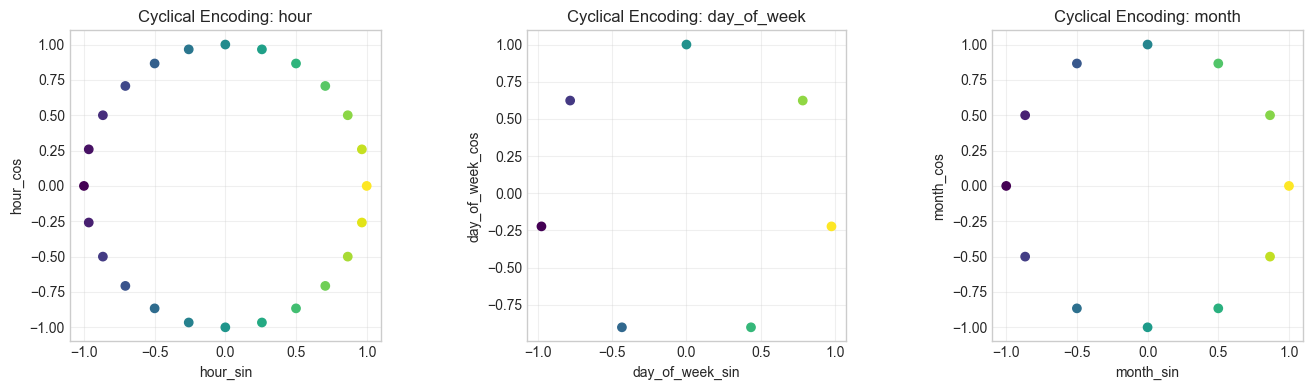

In [15]:
# Visualize cyclical encoding
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (col, max_val) in zip(axes, [("hour", 24), ("day_of_week", 7), ("month", 12)]):
    sample = df[[f"{col}_sin", f"{col}_cos"]].drop_duplicates().sort_values(f"{col}_sin")
    ax.scatter(sample[f"{col}_sin"], sample[f"{col}_cos"], c=range(len(sample)), cmap='viridis')
    ax.set_xlabel(f"{col}_sin")
    ax.set_ylabel(f"{col}_cos")
    ax.set_title(f"Cyclical Encoding: {col}")
    ax.set_aspect('equal')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{BASE_PATH}/outputs/cyclical_encoding.png", dpi=150, bbox_inches='tight')
plt.show()

### 1.6 Define Feature Set

In [16]:
# ============================================================
# 1.6 DEFINE FEATURE SET
# ============================================================
# Columns to exclude from features
DROP_COLS = [
    "datetime", "Date", "Time",  # Identifiers
    "CO_level",  # Leakage! Derived from target
    TARGET_COL,  # Target variable
    # Drop linear temporal features (keep only cyclical)
    "hour", "day_of_week", "month",
]

# Get feature columns
feature_cols = [c for c in df.columns if c not in DROP_COLS and c in df.select_dtypes(include=[np.number]).columns]

print(f"Number of features: {len(feature_cols)}")
print(f"\nFeature columns:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

Number of features: 36

Feature columns:
   1. PT08_S1_CO
   2. C6H6_GT
   3. PT08_S2_NMHC
   4. Nox_GT
   5. PT08_S3_Nox
   6. NO2_GT
   7. PT08_S4_NO2
   8. PT08_S5_O3
   9. T
  10. RH
  11. AH
  12. is_weekend
  13. hour_sin
  14. hour_cos
  15. day_of_week_sin
  16. day_of_week_cos
  17. month_sin
  18. month_cos
  19. CO_GT_lag_1h
  20. PT08_S1_CO_lag_1h
  21. CO_GT_lag_2h
  22. PT08_S1_CO_lag_2h
  23. CO_GT_lag_3h
  24. PT08_S1_CO_lag_3h
  25. CO_GT_lag_6h
  26. PT08_S1_CO_lag_6h
  27. CO_GT_lag_12h
  28. PT08_S1_CO_lag_12h
  29. CO_GT_lag_24h
  30. PT08_S1_CO_lag_24h
  31. CO_GT_rolling_mean_6h
  32. CO_GT_rolling_std_6h
  33. CO_GT_rolling_mean_12h
  34. CO_GT_rolling_std_12h
  35. CO_GT_rolling_mean_24h
  36. CO_GT_rolling_std_24h


### 1.7 Chronological Train/Val/Test Split

In [17]:
# ============================================================
# 1.7 CHRONOLOGICAL SPLIT (65/15/20)
# ============================================================
# IMPORTANT: Time-based split to prevent data leakage!
# DO NOT use random splitting for time series data

df = df.sort_values("datetime").reset_index(drop=True)

n = len(df)
n_train = int(0.65 * n)
n_val = int(0.15 * n)
n_test = n - n_train - n_val

train_df = df.iloc[:n_train].copy()
val_df = df.iloc[n_train:n_train + n_val].copy()
test_df = df.iloc[n_train + n_val:].copy()

print("="*60)
print("CHRONOLOGICAL SPLIT")
print("="*60)
print(f"Train: {len(train_df):,} samples ({len(train_df)/n*100:.1f}%)")
print(f"Val:   {len(val_df):,} samples ({len(val_df)/n*100:.1f}%)")
print(f"Test:  {len(test_df):,} samples ({len(test_df)/n*100:.1f}%)")
print(f"Total: {n:,} samples")

print(f"\nDate Ranges:")
print(f"Train: {train_df['datetime'].min()} → {train_df['datetime'].max()}")
print(f"Val:   {val_df['datetime'].min()} → {val_df['datetime'].max()}")
print(f"Test:  {test_df['datetime'].min()} → {test_df['datetime'].max()}")

CHRONOLOGICAL SPLIT
Train: 4,972 samples (65.0%)
Val:   1,147 samples (15.0%)
Test:  1,531 samples (20.0%)
Total: 7,650 samples

Date Ranges:
Train: 2004-03-11 19:00:00 → 2004-12-05 15:00:00
Val:   2004-12-05 16:00:00 → 2005-01-29 10:00:00
Test:  2005-01-29 11:00:00 → 2005-04-04 14:00:00


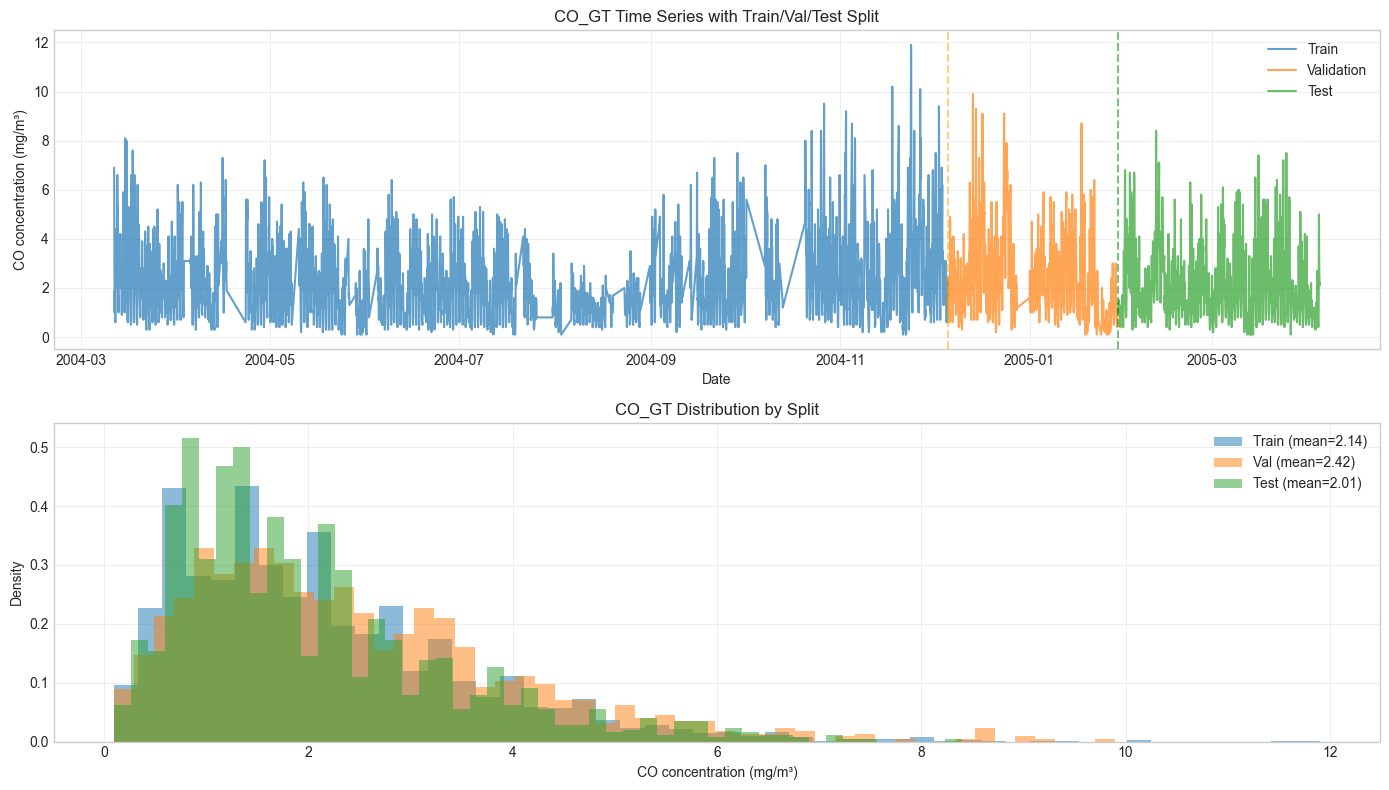

In [18]:
# Visualize split
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Time series with split regions
ax = axes[0]
ax.plot(train_df["datetime"], train_df[TARGET_COL], label="Train", alpha=0.7)
ax.plot(val_df["datetime"], val_df[TARGET_COL], label="Validation", alpha=0.7)
ax.plot(test_df["datetime"], test_df[TARGET_COL], label="Test", alpha=0.7)
ax.axvline(val_df["datetime"].min(), color='orange', linestyle='--', alpha=0.5)
ax.axvline(test_df["datetime"].min(), color='green', linestyle='--', alpha=0.5)
ax.set_title(f"{TARGET_COL} Time Series with Train/Val/Test Split")
ax.set_xlabel("Date")
ax.set_ylabel("CO concentration (mg/m³)")
ax.legend()
ax.grid(alpha=0.3)

# Distribution comparison
ax = axes[1]
ax.hist(train_df[TARGET_COL], bins=50, alpha=0.5, label=f'Train (mean={train_df[TARGET_COL].mean():.2f})', density=True)
ax.hist(val_df[TARGET_COL], bins=50, alpha=0.5, label=f'Val (mean={val_df[TARGET_COL].mean():.2f})', density=True)
ax.hist(test_df[TARGET_COL], bins=50, alpha=0.5, label=f'Test (mean={test_df[TARGET_COL].mean():.2f})', density=True)
ax.set_title(f"{TARGET_COL} Distribution by Split")
ax.set_xlabel("CO concentration (mg/m³)")
ax.set_ylabel("Density")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{BASE_PATH}/outputs/train_val_test_split.png", dpi=150, bbox_inches='tight')
plt.show()

### 1.8 Feature Scaling

In [19]:
# ============================================================
# 1.8 FEATURE SCALING
# ============================================================
# IMPORTANT: Fit scaler on training data ONLY, then transform all splits

# Extract feature matrices
X_train = train_df[feature_cols].values
X_val = val_df[feature_cols].values
X_test = test_df[feature_cols].values

# Extract targets
y_train = train_df[TARGET_COL].values
y_val = val_df[TARGET_COL].values
y_test = test_df[TARGET_COL].values

# Scale features
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

print("Feature scaling complete (StandardScaler)")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_val_scaled:   {X_val_scaled.shape}")
print(f"X_test_scaled:  {X_test_scaled.shape}")

Feature scaling complete (StandardScaler)
X_train_scaled: (4972, 36)
X_val_scaled:   (1147, 36)
X_test_scaled:  (1531, 36)


In [20]:
# Scale target (helpful for neural networks)
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

print("\nTarget scaling complete (for neural networks)")
print(f"y_train: mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"y_train_scaled: mean={y_train_scaled.mean():.4f}, std={y_train_scaled.std():.4f}")


Target scaling complete (for neural networks)
y_train: mean=2.14, std=1.44
y_train_scaled: mean=0.0000, std=1.0000


### 1.9 Helper Functions

In [21]:
# ============================================================
# 1.9 HELPER FUNCTIONS
# ============================================================

def calculate_metrics(y_true, y_pred):
    """
    Calculate all required regression metrics.
    
    Returns:
        dict with RMSE, MAE, R², MAPE
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE - handle zeros to avoid division by zero
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    return {
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "MAPE": mape
    }


def print_metrics(metrics, model_name="Model"):
    """Pretty print metrics."""
    print(f"\n{'='*40}")
    print(f"{model_name} Performance Metrics")
    print(f"{'='*40}")
    print(f"RMSE:  {metrics['RMSE']:.4f}")
    print(f"MAE:   {metrics['MAE']:.4f}")
    print(f"R²:    {metrics['R2']:.4f}")
    print(f"MAPE:  {metrics['MAPE']:.2f}%")


def create_sequences(X, y, seq_length=24):
    """
    Create sequences for LSTM/GRU training.
    
    Args:
        X: Feature matrix (n_samples, n_features)
        y: Target vector (n_samples,)
        seq_length: Number of time steps to look back
    
    Returns:
        X_seq: (n_sequences, seq_length, n_features)
        y_seq: (n_sequences,)
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)


def plot_predictions(y_true, y_pred, title="Predictions vs True Values", save_path=None):
    """Plot predictions vs true values."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot
    ax = axes[0]
    ax.scatter(y_true, y_pred, alpha=0.3, s=10)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect prediction')
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predictions")
    ax.set_title(f"{title}\n(Scatter)")
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Time series comparison (first 200 points)
    ax = axes[1]
    n_show = min(200, len(y_true))
    ax.plot(range(n_show), y_true[:n_show], label='True', alpha=0.7)
    ax.plot(range(n_show), y_pred[:n_show], label='Predicted', alpha=0.7)
    ax.set_xlabel("Time Index")
    ax.set_ylabel("CO concentration (mg/m³)")
    ax.set_title(f"{title}\n(First {n_show} samples)")
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


print("Helper functions defined:")
print("  - calculate_metrics(y_true, y_pred)")
print("  - print_metrics(metrics, model_name)")
print("  - create_sequences(X, y, seq_length)")
print("  - plot_predictions(y_true, y_pred, title, save_path)")

Helper functions defined:
  - calculate_metrics(y_true, y_pred)
  - print_metrics(metrics, model_name)
  - create_sequences(X, y, seq_length)
  - plot_predictions(y_true, y_pred, title, save_path)


In [22]:
# Test metrics function with dummy data
dummy_true = np.array([1, 2, 3, 4, 5])
dummy_pred = np.array([1.1, 2.2, 2.9, 4.1, 5.2])
test_metrics = calculate_metrics(dummy_true, dummy_pred)
print("Test metrics calculation:")
print_metrics(test_metrics, "Dummy Test")

Test metrics calculation:

Dummy Test Performance Metrics
RMSE:  0.1483
MAE:   0.1400
R²:    0.9890
MAPE:  5.97%


### 1.10 Save Preprocessed Data

In [23]:
# ============================================================
# 1.10 SAVE PREPROCESSED DATA
# ============================================================

# Create DataFrames with scaled features
train_scaled_df = train_df.copy()
val_scaled_df = val_df.copy()
test_scaled_df = test_df.copy()

train_scaled_df[feature_cols] = X_train_scaled
val_scaled_df[feature_cols] = X_val_scaled
test_scaled_df[feature_cols] = X_test_scaled

# Add split labels
train_scaled_df["split"] = "train"
val_scaled_df["split"] = "val"
test_scaled_df["split"] = "test"

# Combine and save
cols_to_keep = ["datetime"] + feature_cols + [TARGET_COL, "split"]
full_scaled = pd.concat(
    [train_scaled_df[cols_to_keep], val_scaled_df[cols_to_keep], test_scaled_df[cols_to_keep]],
    ignore_index=True
)

print(f"Final preprocessed dataset shape: {full_scaled.shape}")
print(f"\nSplit distribution:")
print(full_scaled["split"].value_counts())

Final preprocessed dataset shape: (7650, 39)

Split distribution:
split
train    4972
test     1531
val      1147
Name: count, dtype: int64


In [24]:
# Save all artifacts
output_dir = f"{BASE_PATH}/outputs"

# 1. Preprocessed data
csv_path = f"{output_dir}/air_quality_preprocessed.csv"
full_scaled.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")

# 2. Feature scaler
scaler_path = f"{output_dir}/feature_scaler.pkl"
joblib.dump(feature_scaler, scaler_path)
print(f"Saved: {scaler_path}")

# 3. Target scaler
target_scaler_path = f"{output_dir}/target_scaler.pkl"
joblib.dump(target_scaler, target_scaler_path)
print(f"Saved: {target_scaler_path}")

# 4. Feature column names (for consistent ordering)
feature_cols_path = f"{output_dir}/feature_cols.pkl"
joblib.dump(feature_cols, feature_cols_path)
print(f"Saved: {feature_cols_path}")

# 5. Save numpy arrays for direct use
np.savez(
    f"{output_dir}/preprocessed_arrays.npz",
    X_train=X_train_scaled,
    X_val=X_val_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_train_scaled=y_train_scaled,
    y_val_scaled=y_val_scaled,
    y_test_scaled=y_test_scaled,
)
print(f"Saved: {output_dir}/preprocessed_arrays.npz")

Saved: ./outputs/air_quality_preprocessed.csv
Saved: ./outputs/feature_scaler.pkl
Saved: ./outputs/target_scaler.pkl
Saved: ./outputs/feature_cols.pkl
Saved: ./outputs/preprocessed_arrays.npz


### 1.11 Data Loading Template (for modeling notebooks)

In [25]:
# ============================================================
# TEMPLATE: Loading preprocessed data for modeling
# Copy this to your Block 3 / Block 4 notebooks
# ============================================================

print("""
# ========================================
# COPY THIS TO YOUR MODELING NOTEBOOKS
# ========================================

import numpy as np
import joblib

# Load preprocessed arrays
data = np.load("outputs/preprocessed_arrays.npz")
X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]

# For neural networks (scaled target):
y_train_scaled = data["y_train_scaled"]
y_val_scaled = data["y_val_scaled"]
y_test_scaled = data["y_test_scaled"]

# Load scalers (to inverse transform predictions)
feature_scaler = joblib.load("outputs/feature_scaler.pkl")
target_scaler = joblib.load("outputs/target_scaler.pkl")

# Load feature names
feature_cols = joblib.load("outputs/feature_cols.pkl")

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

# For LSTM/GRU - create sequences:
def create_sequences(X, y, seq_length=24):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)

SEQ_LENGTH = 24  # Use past 24 hours
X_train_seq, y_train_seq = create_sequences(X_train, y_train_scaled, SEQ_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val, y_val_scaled, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_scaled, SEQ_LENGTH)

print(f"X_train_seq: {X_train_seq.shape}")  # (samples, seq_length, features)
""")


# ========================================
# COPY THIS TO YOUR MODELING NOTEBOOKS
# ========================================

import numpy as np
import joblib

# Load preprocessed arrays
data = np.load("outputs/preprocessed_arrays.npz")
X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]

# For neural networks (scaled target):
y_train_scaled = data["y_train_scaled"]
y_val_scaled = data["y_val_scaled"]
y_test_scaled = data["y_test_scaled"]

# Load scalers (to inverse transform predictions)
feature_scaler = joblib.load("outputs/feature_scaler.pkl")
target_scaler = joblib.load("outputs/target_scaler.pkl")

# Load feature names
feature_cols = joblib.load("outputs/feature_cols.pkl")

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

# For LSTM/GRU - create sequences:
def create_sequences(X, y, seq_length=24):
    Xs, ys = [], []
    for i in range(le

## Summary

### Preprocessing Complete!

**Data processed:**
- Original: 9,471 rows (114 empty rows at end of file)
- After datetime parsing: 9,357 rows
- After dropping missing CO_GT: ~7,674 rows
- After lag/rolling features: ~7,650 rows

**Features created:**
- Original sensor readings (PT08_S1_CO, C6H6_GT, etc.)
- Meteorological (T, RH, AH)
- Cyclical temporal (hour_sin/cos, day_of_week_sin/cos, month_sin/cos)
- is_weekend flag
- Lag features (1h, 2h, 3h, 6h, 12h, 24h for CO_GT and PT08_S1_CO)
- Rolling statistics (6h, 12h, 24h mean/std for CO_GT)

**Splits:**
- Train: 65% (earliest data)
- Validation: 15% (middle period)
- Test: 20% (most recent data)

**Files saved:**
- `outputs/air_quality_preprocessed.csv`
- `outputs/preprocessed_arrays.npz`
- `outputs/feature_scaler.pkl`
- `outputs/target_scaler.pkl`
- `outputs/feature_cols.pkl`

**Next steps:**
1. Block 3: Train Random Forest / XGBoost / SVR
2. Block 4: Train LSTM / GRU with sequences